In [9]:
print("retest")

FOLD = '/kaggle/working/'
import os 

retest


In [10]:
import shutil

# Function to remove a folder and its contents
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Folder {path} and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")

# Specify the path of the folder to be removed
folder_path = os.path.join(FOLD, 'dataset')

# Call the function to remove the folder
remove_folder(folder_path)

Folder /kaggle/working/dataset and its contents successfully removed.


In [11]:
!git clone https://github.com/QuanHoangNgoc/Container.git dataset

Cloning into 'dataset'...
remote: Enumerating objects: 6739, done.
remote: Total 6739 (delta 0), reused 0 (delta 0), pack-reused 6739
Receiving objects: 100% (6739/6739), 140.80 MiB | 43.57 MiB/s, done.
Updating files: 100% (7024/7024), done.


# "Source Code"

In [12]:
######################################################################################
# Const
######################################################################################
import os
# STORE_ALL_DATA_PUT_ALL = False
# CNT_EXTRACT = -1
# NAME = ['complex_fd', 'org_image', 'enh_image', 'gabor', 'glcm', 'hog_fd',
#         'hog_image', 'lbp_fd', 'lbp_image', 'emw_fd', 'e_image', 'w_image']


CLEAR_LOG = False  # clear file log (if need)

LABEL = os.listdir(FOLD + '/dataset/Training')
FOLDER_DATASET = '/content/dataset'


FEATURE_PIPELINE = ([(0, 0)], [(3, 0)])  # (feature_id, feature_type)


example_code = True
if(example_code == True):
    print("Label: ", LABEL)
    print("Folder Data: ", FOLDER_DATASET)
    

Label:  ['meningioma', 'notumor', 'glioma', 'pituitary']
Folder Data:  /content/dataset


In [13]:
######################################################################################
# Set Up
######################################################################################
import skimage as ski
import keras
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
# import Const
import math

if (example_code):
    print("ski version: ", ski.__version__)
    print("keras version: ", keras.__version__)
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("sklearn version: ", skl.__version__)


2024-05-10 06:13:31.720156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 06:13:31.720254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 06:13:31.889576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ski version:  0.22.0
keras version:  3.2.1
numpy version:  1.26.4
pandas version:  2.2.2
sklearn version:  1.2.2


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [image]
 [(dtype('float64'), <class 'numpy.ndarray'>), (512, 512)] 
 [(0.0, 1.0), (0.11966130873736214, 0.024119580030785556, '2.41 %')] 
 [0, '2.1 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <<module>> 
 @@@ image 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
image.shape (512, 512) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


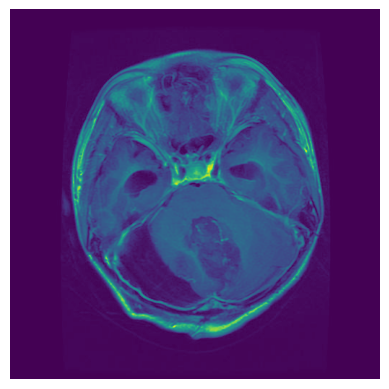

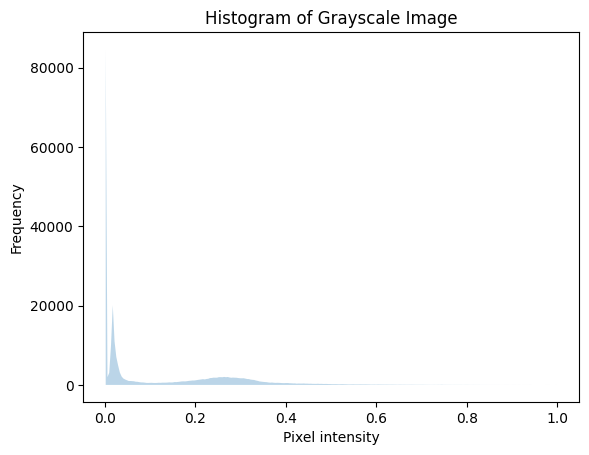

In [15]:
######################################################################################
# Utils
######################################################################################
import logging
from absl import logging as absl_logging
from skimage import io, exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
# from SetUp import *
import inspect


######################################################################################################
# NORMAL UTIL
######################################################################################################
def get_current_method_name(index=2):
    current_frame = inspect.stack()[index]
    method_name = current_frame.function
    return "<" + method_name + ">"


NUM_PRT_SC = int(1e18)


def setup_logging():
    # Set the log file path
    _log_file = os.path.join(os.getcwd(), '_log')
    if not os.path.exists(_log_file):
        os.makedirs(_log_file)
    _log_file = os.path.join(_log_file, 'log.txt')
    if (CLEAR_LOG and os.path.exists(_log_file)):
        os.remove(_log_file)

    # format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    # Configure the Python logging to write to the log file
    logging.basicConfig(filename=_log_file, level=logging.INFO, format=None)
    # Redirect absl logging to the Python logging
    absl_logging.use_python_logging()
    absl_logging.info("\n\n")


setup_logging()


class ut:
    _active = True

    def __init__(self):
        pass

    def act(active):
        ut._active = active
        global NUM_PRT_SC
        if NUM_PRT_SC > 2:
            NUM_PRT_SC = 2
        else:
            NUM_PRT_SC = int(1e18)

    def prt_section():
        global NUM_PRT_SC
        if NUM_PRT_SC < 1:
            return
        else:
            NUM_PRT_SC -= 1
        logging.info("~" * int(77 * 1))
        print("~" * int(77 * 1), flush=True)

    def mess(*mess):
        if ut._active == False:
            return
        ut.prt_section()
        out = '# '
        func_dir = get_current_method_name()
        if (func_dir not in ['<over>', '<note_verbose>']):
            out += get_current_method_name() + "\n"

        for arg in mess:
            out += str(arg) + " "
        global absl_logging
        absl_logging.info(out)
        print(out, flush=True)
        ut.prt_section()

    def note_verbose(flag, title):
        if ut._active == False:
            return
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__verbose__:", func_dir, "\n", "@@@", title)
        # ut.prt_section()

    def over(val, var_name=None):
        if ut._active == False:
            return
        if var_name == None:
            var_name = "{}".format(get_current_method_name())
        else:
            var_name = "{1} \n [{0}]".format(var_name,
                                             get_current_method_name())
        # ut.prt_section()
        try:
            ratio = val.std()**2/(val.max()-val.min()) * 100
            ratio = round(ratio, 2)
            ut.mess(
                "__var__:",
                var_name + "\n",
                [(val.dtype, type(val)), val.shape], "\n",
                [(val.min(), val.max()), (val.mean(),
                                          val.std() ** 2, str(ratio) + " %")], "\n",
                [np.sum(np.isnan(val)), str(
                    round(sys.getsizeof(val)/10**6, 2)) + " Mb"],
            )
        except:
            try:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), len(val), "no-min-max-mean"),
                )
            except:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), "no-shape", "no-min-max-mean"),
                )
        # ut.prt_section()

    def error(tilte):
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__error__:", func_dir, "@@@", tilte)
        # ut.prt_section()
        assert 1 == 0


######################################################################################################
# SKI UTIL
######################################################################################################
def retype_image(image: np.ndarray, istype: str):
    if (istype not in ['float', 'ubyte', 'int']):
        ut.error()
    if (istype == 'float'):
        return ski.util.img_as_float(image)
    if (istype == 'ubyte'):
        return ski.util.img_as_ubyte(image)
    if (istype == 'int'):
        return ski.util.img_as_int(image)
    ut.error()


def revalue_image(image, in_range, out_range):
    return ski.exposure.rescale_intensity(image, in_range=in_range, out_range=out_range)


def show_image(image: np.ndarray, choose=1):
    try:
        assert (choose == 0)
        out = ski.util.img_as_uint(image) # Convert to int
        plt.imshow(out)
        plt.axis('off')  # Optional: to hide the axis
        plt.show()
    except:
        # Display the image using skimage's viewer
        out = ski.util.img_as_uint(image) # Convert to int
        print('cmap = gray')
        plt.imshow(out, cmap='gray')
        plt.axis('off')  # Optional: to hide the axis
        plt.show()


def read_image(path: str, as_gray=True):
    image = ski.io.imread(path, as_gray=as_gray)
    image = ski.img_as_float(image)
    return image

def recolor_image(image, channel):
    if (channel not in ['gray', 'rgb']):
        ut.error()
    if (channel == 'gray'):
        return ski.color.rgb2gray(image)
    if (channel == 'rgb'):
        return ski.color.gray2rgb(image)
    ut.error()


def show_his(image):
    try:
        colors = ('red', 'green', 'blue')
        for color, channel in zip(colors, image.transpose((2, 0, 1))):
            hist, hist_centers = exposure.histogram(channel)
#             hist /= len(hist.flatten())
            plt.fill_between(hist_centers, hist, label=color, alpha=0.3)
        plt.legend()
        plt.title('Histogram for Each Color Channel')
    except:
        # Compute the histogram
        hist, hist_centers = exposure.histogram(image)
#         hist /= len(hist.flatten())
        # Display the histogram
        plt.fill_between(hist_centers, hist, alpha=0.3)
        plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()


if (example_code):
    # read show image simply
    path = os.path.join(os.getcwd(), FOLD + '/dataset/Testing/glioma/Te-glTr_0000.jpg')
    image = read_image(path)
    ut.over(image, "image")
    ut.note_verbose(True, title="image")
    ut.mess("image.shape", image.shape)
    show_image(image, 0)
    show_his(image)

    absl_logging.warning("WARN")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (221, 228)] 
 [(0.0392156862745098, 1.0), (0.35446597151204695, 0.050374892963617225, '5.24 %')] 
 [0, '0.4 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


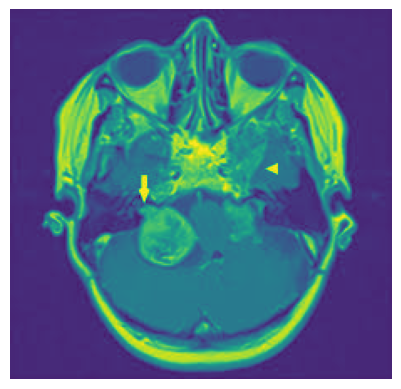

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (500, 455)] 
 [(0.0, 1.0), (0.2957292824822237, 0.06156329470151398, '6.16 %')] 
 [0, '1.82 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


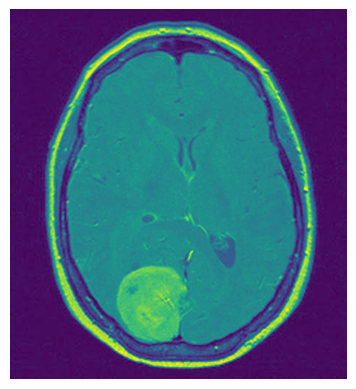

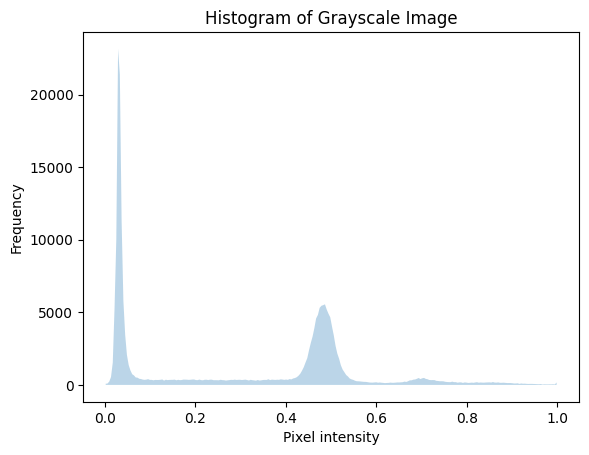

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (500, 455)] 
 [(0.0, 1.0), (0.5565805472958415, 0.07334873451977601, '7.33 %')] 
 [0, '1.82 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


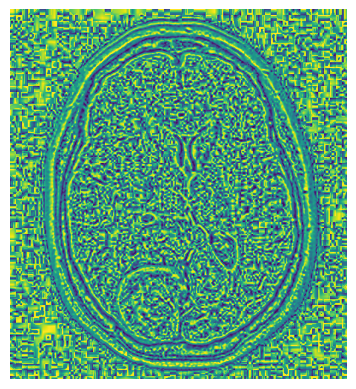

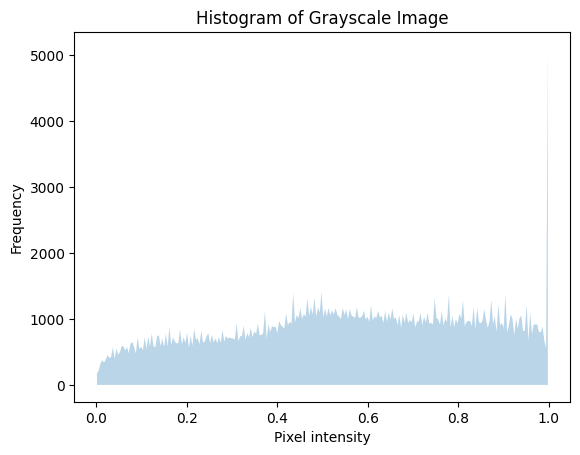

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (256, 256)] 
 [(0.0, 0.9921568627450981), (0.24763345157398892, 0.022310558671600075, '2.25 %')] 
 [0, '0.52 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


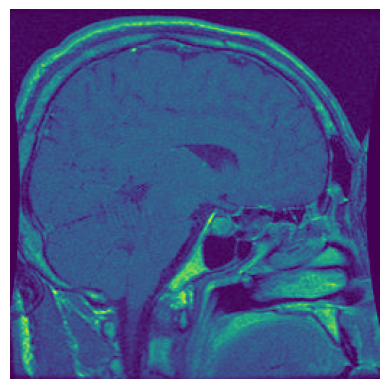

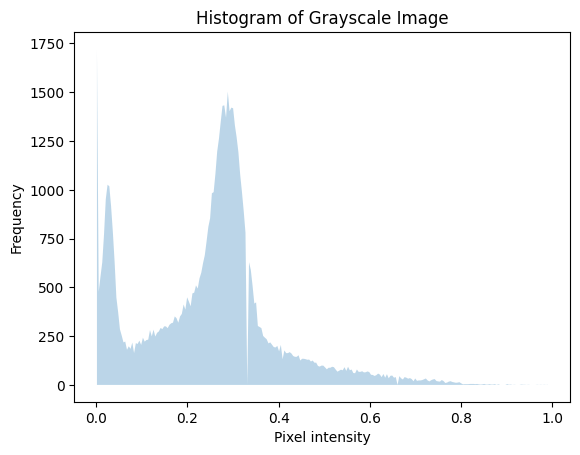

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (256, 256)] 
 [(0.0, 1.0), (0.5247350623492989, 0.07354164269964705, '7.35 %')] 
 [0, '0.52 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


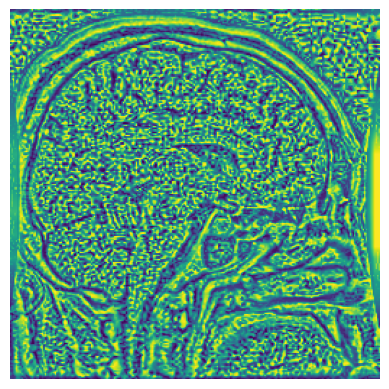

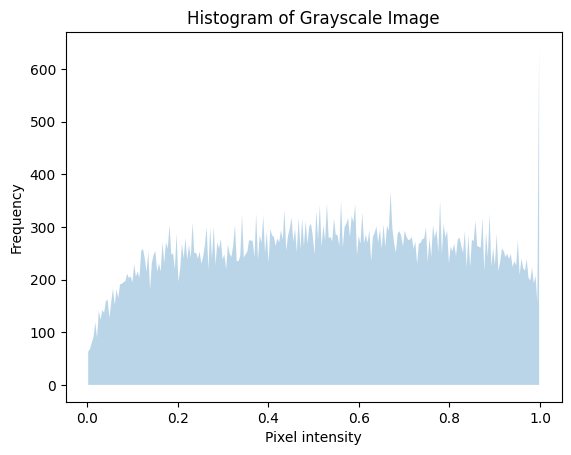

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (236, 211)] 
 [(0.0, 1.0), (0.25341952027015313, 0.027322197242994912, '2.73 %')] 
 [0, '0.4 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


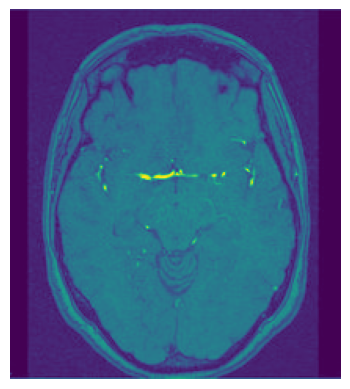

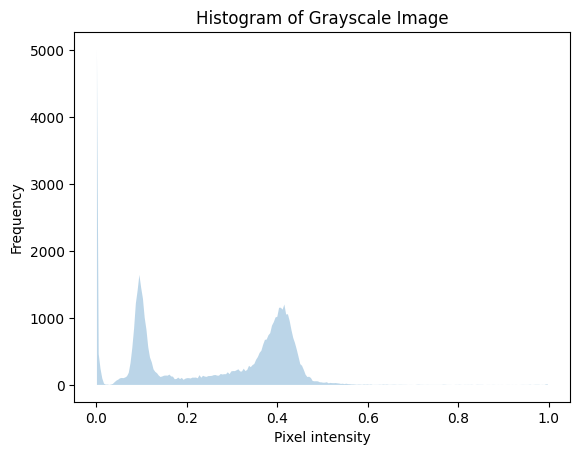

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (236, 211)] 
 [(0.0, 1.0), (0.5677967873630294, 0.0802770704303575, '8.03 %')] 
 [0, '0.4 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


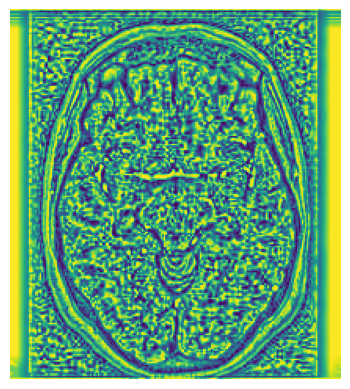

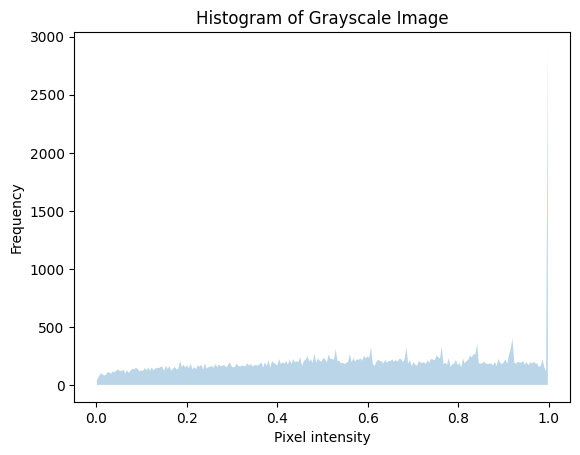

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (512, 512)] 
 [(0.0, 1.0), (0.19628230076210174, 0.0379000011783076, '3.79 %')] 
 [0, '2.1 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


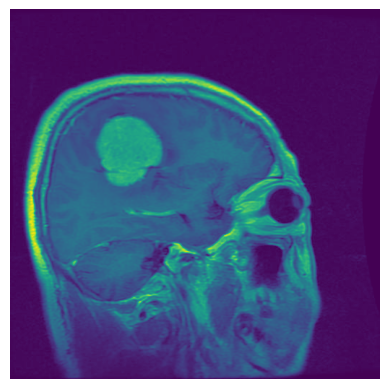

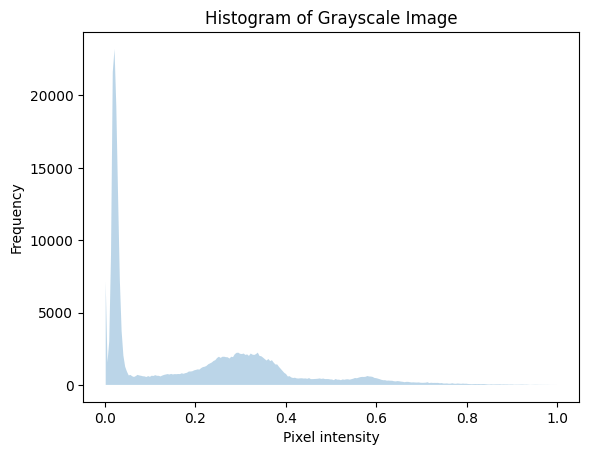

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (512, 512)] 
 [(0.0, 1.0), (0.5715474016526165, 0.06946002036183632, '6.95 %')] 
 [0, '2.1 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


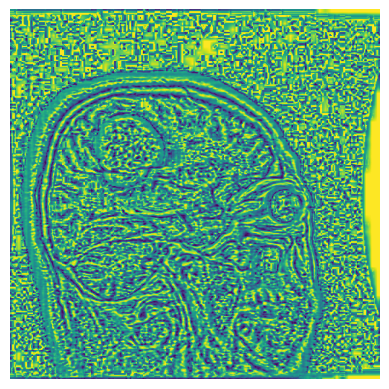

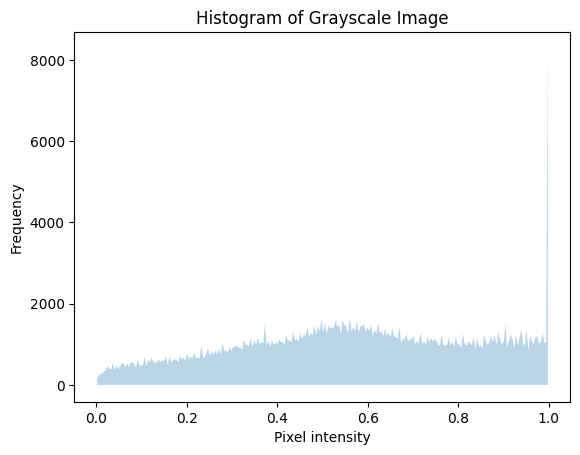

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (351, 321)] 
 [(0.011764705882352941, 1.0), (0.20730661072729367, 0.033681389192778244, '3.41 %')] 
 [0, '0.9 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


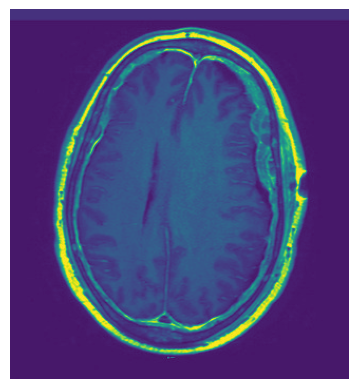

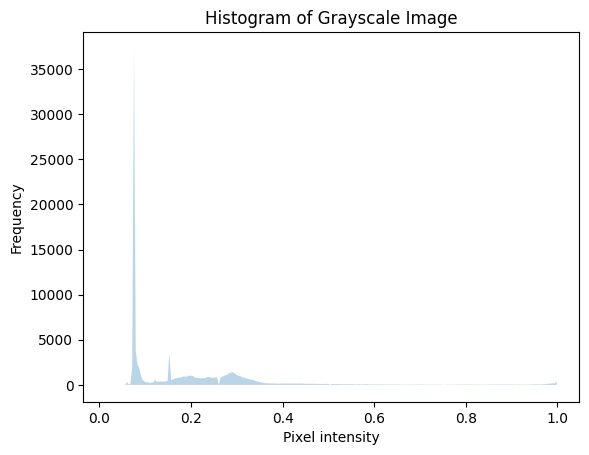

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (351, 321)] 
 [(0.0, 1.0), (0.6756426810768329, 0.09228165761781731, '9.23 %')] 
 [0, '0.9 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


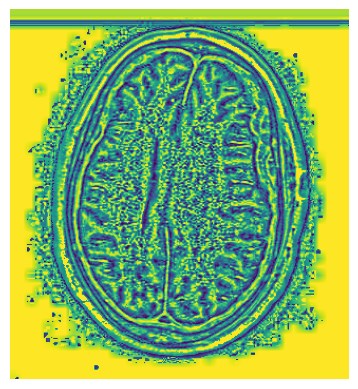

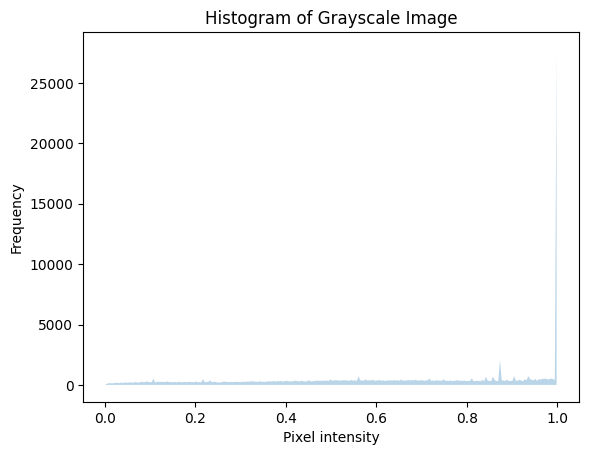

In [18]:
######################################################################################
# Image Enhancemnet
######################################################################################
# from Utils import *

######################################################################################################
# CONST FOR IMAGE
######################################################################################################
COLOR = 'grayscale'
SIZE = (256, 256)
TYPE = 'float'
VALUE = (0, 1)
DISPLAY_IMAGE = False


def copy_mat(x):
    try:
        return x.copy()
    except:
        return x


def check_grayscale(x):
    assert(x.min() >= 0 and x.max() <= 1)


class ExtractLayer(keras.layers.Layer):
    def __init__(self, **_hyparams): super().__init__(**_hyparams)
    def call(self, gray_image): return self.mono_call(gray_image)
    def mono_call(self, *argv): pass


class Enhancement(ExtractLayer):
    def init_params(self):
        # Params
        self.Sigma = 2
        self.Clip_limit_value = 2.0
        self.Tile_grid_size_value = (8, 8)

    def __init__(self):
        super().__init__()
        self.init_params()
        self.Display_image = False

    def mono_call(self, gray_image):
        # check_grayscale(gray_image)
        # Apply Gaussian blur to the image
        blurred_image = ski.filters.gaussian(
            copy_mat(gray_image), sigma=self.Sigma)
        # check_grayscale(blurred_image)
        # Perform the linear combination as per the given expression
        # Note that the images must be in floating point representation for this operation
        combined_image = 1.5 * gray_image - 0.5 * blurred_image
#         combined_image = gray_image
        # Clip the values to the valid range [0, 1] to ensure a valid image
        combined_image = np.clip(combined_image, 0, 1) # Set limit for image
        # check_grayscale(combined_image)

        if(self.Display_image):
            show_image(combined_image, 0)
        # Apply CLAHE
        clahe_image = ski.exposure.equalize_adapthist(
            combined_image,
            clip_limit=self.Clip_limit_value, nbins=256, kernel_size=self.Tile_grid_size_value)
        # check_grayscale(clahe_image)
        return clahe_image


import random
def get_random_file_in_folder(root_folder, K):
    lis = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            lis.append(file_path)
    random.shuffle(lis)
    return lis[:K]


# examples
if (example_code):
    path = os.path.join(os.getcwd(), FOLD + '/dataset/Testing/meningioma/Te-meTr_0002.jpg')
    org_image = read_image(path, as_gray=True)
    ut.over(org_image)
    show_image(org_image, 0)

    files = get_random_file_in_folder(FOLD + '/dataset', K=5)
    for path in files:
        path = os.path.join(os.getcwd(), path)
        org_image = read_image(path, as_gray=True)
        ut.over(org_image)
        show_image(org_image, 0)
        show_his(org_image)

        # Enhance image
        enh = Enhancement()
        image = enh.call(org_image)
        ut.over(image)
        show_image(image, 0)
        show_his(image)


In [22]:
######################################################################################
# Extractor
######################################################################################
# import Const
import json
from collections import defaultdict
from joblib import Parallel, delayed
import pywt
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from skimage import io, color, img_as_ubyte
# from Image import *


import numpy as np
from skimage import io, color, filters
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt


class HOGExtraction(ExtractLayer):
    def __init__(self):
        super().__init__()
        self.DisplayImage = DISPLAY_IMAGE

    def mono_call(self, gray_image):
        # Compute HOG features
        # pixels_per_cell: Size (in pixels) of a cell.
        # cells_per_block: Number of cells in each block.
        # orientations: Number of orientation bins.
        # block_norm: Block normalization method.
        # visualize: If True, also returns an image of the HOG.
        fd, hog_image = hog(copy_mat(gray_image), pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                            orientations=9, block_norm='L2-Hys', visualize=True)

        # fd contains the HOG feature descriptor
        # hog_image contains the visualization of HOG if visualize=True
        # Display the HOG image
        if (self.DisplayImage):
            import matplotlib.pyplot as plt
            plt.imshow(hog_image, cmap='gray')
            plt.show()
        return fd, hog_image


######################################################################################
# Statis
######################################################################################
from skimage import filters
class StatisExtraction(ExtractLayer):
    def __init__(self):
        super().__init__()
        self.DisplayImage = DISPLAY_IMAGE
        self.P = 3

    def calculate_statistics(self, flattened): pass

    def mono_call(self, gray_image):
        size = gray_image.shape
        size = (size[0]//self.P, size[1]//self.P)
        resize_image = ski.transform.resize(gray_image, size, anti_aliasing=True)
        resize_image = retype_image(resize_image, istype='ubyte')

        # Reduce size of imgae to reduce ram
        local_mean = filters.rank.mean(resize_image, np.ones((3, 3))).flatten()
        local_entropy = filters.rank.entropy(resize_image, np.ones((3, 3))).flatten()
        local_max = filters.rank.maximum(resize_image, np.ones((3, 3))).flatten()
        # local_min = filters.rank.minimum(resize_image, np.ones((3, 3))).flatten()
        fd = np.concatenate((local_max, local_mean, local_entropy), axis=0)
        return fd


######################################################################################
# Putall
######################################################################################
class Putall(ExtractLayer):
    def __init__(self):
        super().__init__()
        self.block_0 = Enhancement()
        self.block_1 = GaborExtraction()
        self.block_2 = LBPExtraction()
        self.block_3 = HOGExtraction()
        self.block_4 = StatisExtraction()
        self.DisplayImage = DISPLAY_IMAGE
        self.Verbose = False

    def call(self, df):
        x_training, y_training = [], []
        for i in range(len(df)):
            folder = df['folder'].iloc[i]
            y = LABEL.index(folder)
            y_training.append(y)
        ut.mess("done y training")
        x_training = joblib_loop(df)
        ut.mess("done x training")
        x_training, y_training = np.array(x_training), np.array(y_training)
        return x_training, y_training

    
_putall = Putall()


def parallel_return_task(path):
    org_image = read_image(path, as_gray=True)
    # !!!In the example above, anti_aliasing=True is used to apply a Gaussian filter
    # to smooth the image before downsampling, which can help reduce aliasing artifacts.
    org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
    x = copy_mat(org_image)

    blocks = [_putall.block_0, _putall.block_1, _putall.block_2,
              _putall.block_3, _putall.block_4]

    for control in FEATURE_PIPELINE:
        z_list = []
        for insight in control:
            block = blocks[insight[0]]
            z = block.call(x)
            if (isinstance(z, tuple) == True):
                z = z[insight[1]]
            z_list.append(z)
        if (len(z_list) > 1):
            out = np.array([])
            for z in z_list:
                out = np.append(out, z.flatten())
        else:
            out = z_list[0]
        x = out
    return x


def joblib_loop(df: pd.DataFrame):
    pics = df['file_path'].to_list()
    return [parallel_return_task(path) for path in pics]
#     return Parallel(n_jobs=8)(delayed(parallel_return_task)(path) for path in pics)


In [23]:
######################################################################################
# FileDataFrame
######################################################################################
from sklearn.model_selection import train_test_split
# from Extractor import *


class FileDataFrame(ExtractLayer):
    def __init__(self): super().__init__()

    def list_files_from_start_folder(self, start_folder_path):
        files, info, filenames = [], [], []
        for root, _, file_name_list in os.walk(start_folder_path):
            for filename in file_name_list:
                file_path = os.path.join(root, filename)
                parent_folder_name = os.path.basename(
                    os.path.dirname(file_path))
                files.append(file_path)
                info.append(parent_folder_name)
                filenames.append(filename)
        df = pd.DataFrame(
            {'file_path': files, 'folder': info, 'file_name': filenames})
        return df

    def call(self, start_folder_path):
        return self.list_files_from_start_folder(start_folder_path)


def create_dataframe(root_folder, rate=None):
    fdf = FileDataFrame()
    df = fdf.call(root_folder)
    # print(df)
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    if(rate==None):
        return shuffled_df
    rate = int(rate * len(df)) + 1
    return shuffled_df.iloc[:rate]


def show_info_df(df, name=""):
    ut.note_verbose(True, "show df: " + name)
    ut.mess(df.shape)
    for i in range(len(LABEL)):
        ut.mess(LABEL[i], sum(df['folder'] == LABEL[i]))


# examples
if (1 == 1):
    root_folder = FOLD + '/dataset/Training'
    df = create_dataframe(root_folder, 0.002)
    ut.mess(df)
    show_info_df(df, "small train")

    FEATURE_PIPELINE = ([(0, 0)], [(4, 0)])
    ut.mess("PIPE_LINE: ", FEATURE_PIPELINE)
    x, y = _putall.call(df)
    ut.over(x, "x")
    ut.over(y, "y")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
                                            file_path      folder  \
0   /kaggle/working//dataset/Training/notumor/Tr-n...     notumor   
1   /kaggle/working//dataset/Training/glioma/Tr-gl...      glioma   
2   /kaggle/working//dataset/Training/meningioma/T...  meningioma   
3   /kaggle/working//dataset/Training/pituitary/Tr...   pituitary   
4   /kaggle/working//dataset/Training/pituitary/Tr...   pituitary   
5   /kaggle/working//dataset/Training/glioma/Tr-gl...      glioma   
6   /kaggle/working//dataset/Training/pituitary/Tr...   pituitary   
7   /kaggle/working//dataset/Training/glioma/Tr-gl...      glioma   
8   /kaggle/working//dataset/Training/meningioma/T...  meningioma   
9   /kaggle/working//dataset/Training/meningioma/T...  meningioma   
10  /kaggle/working//dataset/Training/meningioma/T...  meningioma   
11  /kaggle/working//dataset/Training/glioma/Tr-gl...      glioma   

         fi

In [24]:
######################################################################################
# Transformer and get Transform Pipeline data
######################################################################################
# from FileDataFrame import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


class DataExtractToTT:
    def __init__(self):
        self._putall = Putall()

    def flow_from_dataframe(self, df, feature_pipeline):
        FEATURE_PIPELINE = feature_pipeline
        ut.mess("PIPELINE: ", FEATURE_PIPELINE)
        x_2d, y_1d = self._putall.call(df=df)
        return x_2d, y_1d


def get_ins_scaler():
    return StandardScaler()


In [25]:
def get_transform_pipeline_data(step_list, x_2d, y_1d=None, use_fit=False):
    x, y = x_2d.copy(), y_1d.copy()
    for i in range(len(step_list)):
        ut.over(x, "X transform in loop {}".format(i))
        if (use_fit):
            step_list[i].fit(x)
        z = step_list[i].transform(x)
        if (isinstance(z, tuple)):
            x, y = z
        else:
            x = z
    return step_list, x, y


# Sub Exp2: Enh + Statis

In [27]:
# Set up exp
df = create_dataframe(FOLD + '/dataset/Training')
df_test = create_dataframe(FOLD + '/dataset/Testing')
df

,file_path,folder,file_name
0,/kaggle/working//dataset/Training/notumor/Tr-n...,notumor,Tr-no_1519.jpg
1,/kaggle/working//dataset/Training/glioma/Tr-gl...,glioma,Tr-gl_0870.jpg
2,/kaggle/working//dataset/Training/meningioma/T...,meningioma,Tr-me_0735.jpg
3,/kaggle/working//dataset/Training/pituitary/Tr...,pituitary,Tr-pi_1028.jpg
4,/kaggle/working//dataset/Training/pituitary/Tr...,pituitary,Tr-pi_0767.jpg
...,...,...,...
5707,/kaggle/working//dataset/Training/glioma/Tr-gl...,glioma,Tr-gl_0486.jpg
5708,/kaggle/working//dataset/Training/pituitary/Tr...,pituitary,Tr-pi_0553.jpg
5709,/kaggle/working//dataset/Training/pituitary/Tr...,pituitary,Tr-pi_0951.jpg
5710,/kaggle/working//dataset/Training/pituitary/Tr...,pituitary,Tr-pi_0024.jpg


In [28]:
# Extract to tt data
_extract = DataExtractToTT()
x_train, y_train = _extract.flow_from_dataframe(df, FEATURE_PIPELINE)
x_test, y_test = _extract.flow_from_dataframe(df_test, FEATURE_PIPELINE)


ut.over(x_train, "x_train")
ut.over(y_train, "y_train")
ut.over(x_test, "x_test")
ut.over(y_test, "y_test")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <flow_from_dataframe>
PIPELINE:  ([(0, 0)], [(4, 0)]) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <call>
done y training 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <call>
done x training 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <flow_from_dataframe>
PIPELINE:  ([(0, 0)], [(4, 0)]) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <call>
done y training 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [29]:
def save_np_to_file(arr, name):
  np.save(name, arr)

# Save data
arrs = [x_train, y_train, x_test, y_test]
names = ['x_train_{}.npy', 'y_train_{}.npy', 'x_test_{}.npy', 'y_test_{}.npy']
for arr, name in zip(arrs, names):
  save_np_to_file(arr, name.format('enh_statis'))

In [30]:
x_train = np.load(FOLD + 'x_train_enh_statis.npy')
x_test = np.load(FOLD + 'x_test_enh_statis.npy')
y_train = np.load(FOLD + 'y_train_enh_statis.npy')
y_test = np.load(FOLD + 'y_test_enh_statis.npy')

# Transform data to trans data
step_list = [get_ins_scaler(), PCA(0.95)]
step_list, x_train, y_train = get_transform_pipeline_data(
  step_list, x_train, y_train, use_fit=True)
step_list, x_test, y_test = get_transform_pipeline_data(
  step_list, x_test, y_test, use_fit=False)


ut.over(x_train, "x_train")
ut.over(y_train, "y_train")
ut.over(x_test, "x_test")
ut.over(y_test, "y_test")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <get_transform_pipeline_data> 
 [X transform in loop 0]
 [(dtype('float64'), <class 'numpy.ndarray'>), (5712, 21675)] 
 [(0.0, 255.0), (122.21635074951406, 8453.979368466738, '3315.29 %')] 
 [0, '990.46 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <get_transform_pipeline_data> 
 [X transform in loop 1]
 [(dtype('float64'), <class 'numpy.ndarray'>), (5712, 21675)] 
 [(-27.058666826760316, 7.737153866475589), (-1.7778946671082224e-13, 0.9999999999999996, '2.87 %')] 
 [0, '990.46 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <get_transform_pipeline_data> 
 [X transform in loop 0]
 [(dtype('float64'), <class 'numpy.ndarray'>), (1311, 21675)] 
 [(0.0, 2

In [31]:
# !Method to evaluate 

from sklearn.model_selection import cross_val_score, KFold
KF = KFold(n_splits=4, shuffle=True, random_state=42)
def evaluate_cross_valid(hypo_model, x, y, scorer, len_test):
    CV = int(len(x)/len_test)
    results = cross_val_score(hypo_model, x, y, cv=KF,
                              scoring=scorer)  # results of evaluating
    trained_model = skl.base.clone(hypo_model)  # copy and fit model
    trained_model.fit(x, y)
    return results, trained_model


def show_evluation(trained_model, x_test, y_test, name):
    y_pred = trained_model.predict(x_test)
    report = classification_report(y_test, y_pred, digits=4)

    # Print the classification report
    print('Classification Report: {}'.format(name))
    print(report)


def show_heatmap(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    # Create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def evaluate(hypo, name, x_train, y_train, x_test, y_test):
    scorer = make_scorer(accuracy_score)
    results, trained_model = evaluate_cross_valid(hypo, x_train, y_train, scorer, len(x_test))
    try:
        # Access the coefficients/weights of the model
        weights = trained_model.coef_
        ut.over(weights, "weights of {}".format(name))
    except:
        ut.mess("No weights")

    # Overal Seen data
    ut.note_verbose(True, "evaluating... of {}".format(name))
    print("results: ", results)
    print("mean of: ", np.array(results).mean())
    print("std2 of: ", np.array(results).std()**2)

    # Not Seen data
    show_evluation(trained_model, x_train, y_train, name="train result")
    show_evluation(trained_model, x_test, y_test, name="test result")
    show_heatmap(trained_model, x_test, y_test)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <evaluate>
No weights 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of KNN(n=10) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.86554622 0.86764706 0.8557423  0.86414566]
mean of:  0.8632703081232493
std2 of:  2.0443226310132175e-05
Classification Report: train result
              precision    recall  f1-score   support

           0     0.9004    0.7625    0.8257      1339
           1     0.9524    0.9404    0.9464      1595
           2     0.8935    0.9213    0.9072      1321
           3     0.8641    0.9732    0.9154      1457

    accuracy                         0.9027      5712
   macro avg     0.9026    0.8994    0.8987      5712
weighted avg     0.9041    0.9027    0.9011      5712

Classification

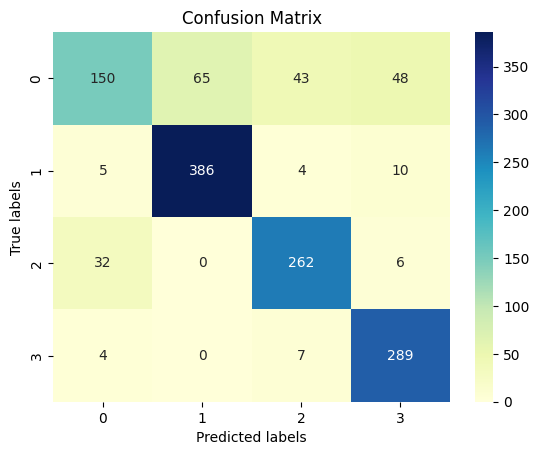

In [32]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


hypo = KNeighborsClassifier(n_neighbors=10)
name = "KNN(n=10)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <evaluate>
No weights 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of KNN(n=5) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.89705882 0.89635854 0.88585434 0.8942577 ]
mean of:  0.8933823529411765
std2 of:  1.995283407480667e-05
Classification Report: train result
              precision    recall  f1-score   support

           0     0.9510    0.8409    0.8926      1339
           1     0.9574    0.9592    0.9583      1595
           2     0.9258    0.9629    0.9440      1321
           3     0.9261    0.9890    0.9565      1457

    accuracy                         0.9400      5712
   macro avg     0.9401    0.9380    0.9379      5712
weighted avg     0.9406    0.9400    0.9391      5712

Classification R

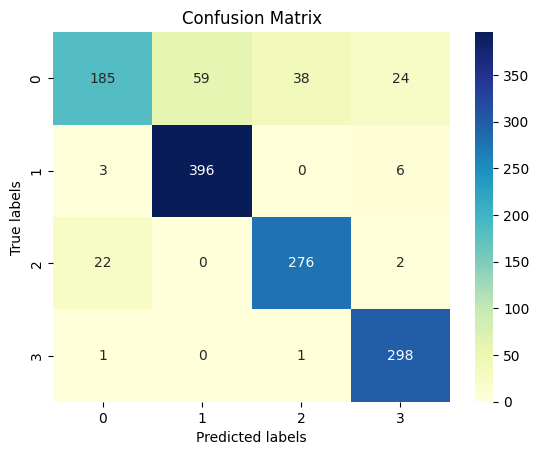

In [34]:
hypo = KNeighborsClassifier(n_neighbors=5)
name = "KNN(n=5)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <evaluate>
No weights 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of KNN(n=3) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.94047619 0.92997199 0.92647059 0.93907563]
mean of:  0.9339985994397759
std2 of:  3.515499336989672e-05
Classification Report: train result
              precision    recall  f1-score   support

           0     0.9544    1.0000    0.9767      1339
           1     0.9975    0.9931    0.9953      1595
           2     1.0000    0.9614    0.9803      1321
           3     1.0000    0.9959    0.9979      1457

    accuracy                         0.9881      5712
   macro avg     0.9880    0.9876    0.9876      5712
weighted avg     0.9886    0.9881    0.9881      5712

Classification R

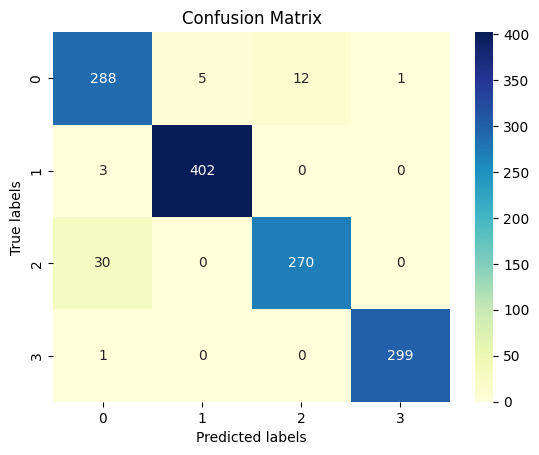

In [38]:
hypo = KNeighborsClassifier(n_neighbors=2)
name = "KNN(n=3)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <evaluate>
No weights 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of KNN(n=1) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.94047619 0.93907563 0.94117647 0.93977591]
mean of:  0.9401260504201681
std2 of:  6.129902941568739e-07
Classification Report: train result
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1339
           1     1.0000    1.0000    1.0000      1595
           2     1.0000    1.0000    1.0000      1321
           3     1.0000    1.0000    1.0000      1457

    accuracy                         1.0000      5712
   macro avg     1.0000    1.0000    1.0000      5712
weighted avg     1.0000    1.0000    1.0000      5712

Classification R

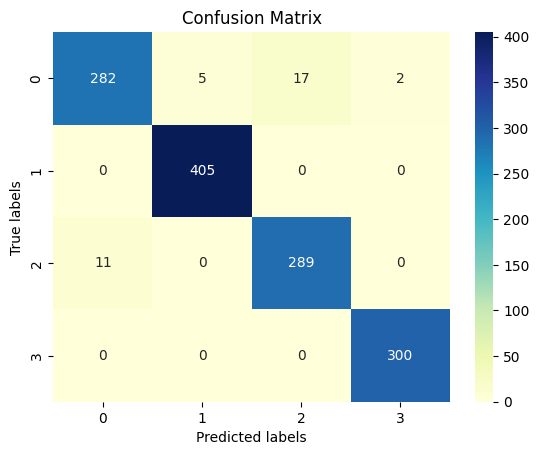

In [36]:
hypo = KNeighborsClassifier(n_neighbors=1)
name = "KNN(n=1)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <evaluate> 
 [weights of SVC(linear)]
 [(dtype('float64'), <class 'numpy.ndarray'>), (6, 2355)] 
 [(-0.04841159375591289, 0.03634314136825556), (-8.011300597720894e-06, 2.6004188278385233e-05, '0.03 %')] 
 [0, '0.11 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of SVC(linear) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.91596639 0.90266106 0.9047619  0.91036415]
mean of:  0.90843837535014
std2 of:  2.681832536936324e-05
Classification Report: train result
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1339
           1     1.0000    1.0000    1.0000      1595
           2     1.0000    1.0000    1.0000      1321
           3     1.0000  

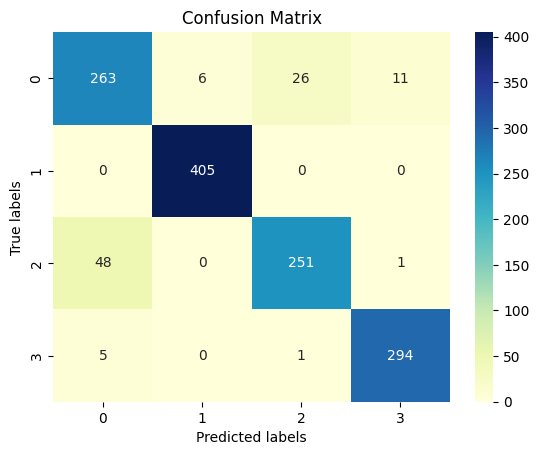

In [39]:
hypo = hypo = SVC(kernel='linear', random_state=42)
name = "SVC(linear)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <evaluate>
No weights 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __verbose__: <evaluate> 
 @@@ evaluating... of SVC(rbf) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results:  [0.91596639 0.90546218 0.90616246 0.92016807]
mean of:  0.9119397759103641
std2 of:  3.9813719605488966e-05
Classification Report: train result
              precision    recall  f1-score   support

           0     0.9270    0.9582    0.9423      1339
           1     0.9827    0.9994    0.9910      1595
           2     0.9952    0.9349    0.9641      1321
           3     0.9802    0.9856    0.9829      1457

    accuracy                         0.9713      5712
   macro avg     0.9713    0.9695    0.9701      5712
weighted avg     0.9719    0.9713    0.9713      5712

Classification 

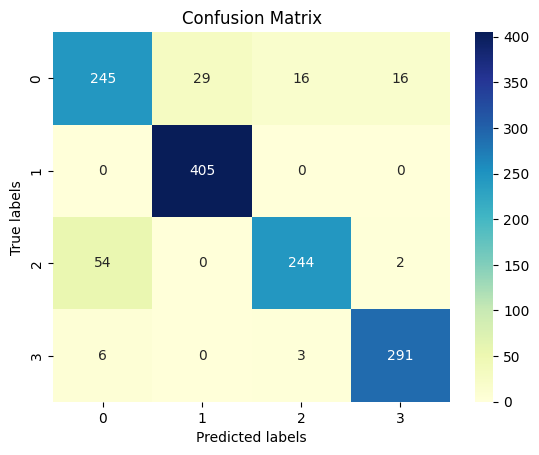

In [40]:
hypo = hypo = SVC(kernel='rbf', random_state=42)
name = "SVC(rbf)"
evaluate(hypo, name, x_train, y_train, x_test, y_test)